# **Colab only for ML**

# Data collecting

In [ ]:
USE_DRIVE   = False
USE_DROPBOX = False
START_FROM  = 0

if USE_DRIVE:
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
        DRIVE_ROOT = "/content/drive/MyDrive"
        print("Google Drive mounted ✓")
    except Exception:
        DRIVE_ROOT = "."
        print("⚠ Drive mount failed — saving locally")
else:
    DRIVE_ROOT = "."
    print("Google Drive disabled — saving locally")

import os, re, time, random, warnings, requests, unicodedata
import numpy as np, pandas as pd
from bs4 import BeautifulSoup as bs
warnings.filterwarnings("ignore")

COMP_ID = "19"
BASE    = "https://soccer365.ru"

SEASON_URLS = {
    "2024-2025": f"{BASE}/competitions/{COMP_ID}/results/",
    "2023-2024": f"{BASE}/competitions/{COMP_ID}/2023-2024/results/",
    "2022-2023": f"{BASE}/competitions/{COMP_ID}/2022-2023/results/",
    "2021-2022": f"{BASE}/competitions/{COMP_ID}/2021-2022/results/",
    "2020-2021": f"{BASE}/competitions/{COMP_ID}/2020-2021/results/",
    "2019-2020": f"{BASE}/competitions/{COMP_ID}/2019-2020/results/",
    "2018-2019": f"{BASE}/competitions/{COMP_ID}/2018-2019/results/",
}

SAVE_PATH   = os.path.join(DRIVE_ROOT, "final_uefa.csv")
DROPBOX_URL = ("https://www.dropbox.com/scl/fi/abcd1234abcd/final_uefa.csv"
               "?rlkey=xyz&dl=1")

HEADERS      = {"User-Agent": "Mozilla/5.0"}
STADIUMS_URL = f"{BASE}/competitions/{COMP_ID}/stadiums/"

STAT_COLS = [
    "xG","Удары","Удары в створ","Блок-но ударов","Сейвы","Владение %","Угловые",
    "Нарушения","Офсайды","Желтые карточки","Красные карточки","Атаки",
    "Опасные атаки","Передачи","Точность передач %","Штрафные удары",
    "Вбрасывания","Навесы"
]

# helpers
def _get(url, tries=3, pause=1):
    for a in range(tries):
        try:
            r = requests.get(url, headers=HEADERS, timeout=20); r.raise_for_status()
            return bs(r.content, "html.parser")
        except Exception:
            if a == tries-1: raise
            time.sleep(pause + random.random())

def all_match_links():
    links = set()
    for season, url in SEASON_URLS.items():
        print(f"Collecting links for {season} …")
        soup = _get(url)
        links.update(BASE + a["href"]
                     for a in soup.select("a.game_link[href]")
                     if "/games/" in a["href"])
    return sorted(links)

def safe_int(txt):
    if txt is None: return np.nan
    t = unicodedata.normalize("NFKD", txt).strip()
    return np.nan if t in {"", "-", "–"} else int(t)

def parse_match(url, idx, total):
    print(f"[{idx:04}/{total}] {url}")
    s  = _get(url)
    t1 = s.select_one("div.live_game.left  a").text.strip()
    g1 = safe_int(s.select_one("div.live_game.left  span").text)
    t2 = s.select_one("div.live_game.right a").text.strip()
    g2 = safe_int(s.select_one("div.live_game.right span").text)
    d  = dict(Команда_1=t1, Голы_1=g1, Команда_2=t2, Голы_2=g2, URL=url)

    for blk in s.select("div.stats_item"):
        title = blk.select_one("div.stats_title").text.strip()
        vals  = [float(re.sub(r"[^\d.\-]", "", x.text)) if x.text.strip() else np.nan
                 for x in blk.select("div.stats_inf")]
        d[f"{title}_1"], d[f"{title}_2"] = vals

    header = s.select_one("#game_events h2").text
    rnd  = re.search(r"(\d+)[\-\s]*тур", header, re.I) \
        or re.search(r"Раунд\s*(\d+)", header, re.I)
    d["Раунд"] = int(rnd.group(1)) if rnd else np.nan
    dt = re.search(r"\d{2}\.\d{2}\.\d{4}", header)
    tm = re.search(r"\d{2}:\d{2}", header)
    d["Дата"] = pd.to_datetime(dt.group(0), dayfirst=True) if dt else pd.NaT
    d["Время"] = tm.group(0) if tm else np.nan

    odds = s.select("table.adv_kef_wgt tr.adv_kef_wgt_odd td span.koeff")
    if odds: d["Кэф_1"], d["Кэф_х"], d["Кэф_2"] = [float(o.text) for o in odds[:3]]

    prev = s.select_one("#preview div.block_body")
    if prev:
        st = prev.select_one("div.preview_item.st")
        if st:
            a = st.select_one("a");    d["Стадион"] = a.text.strip() if a else np.nan
            t = st.select_one("div.img16.weath_tmp span.red")
            d["Градусы"] = t.text.strip() if t else np.nan
            w = st.select("span.min_gray")
            d["Погода"] = w[1].text.strip() if len(w) > 1 else np.nan
        for it in prev.select("div.preview_item"):
            if "Зрителей" in it.text:
                d["Зрители"] = int(re.sub(r"[^\d]", "", it.text)); break

    for k in ["Зрители","Погода","Градусы","Стадион","Кэф_1","Кэф_х","Кэф_2"]:
        d.setdefault(k, np.nan)
    for c in STAT_COLS:
        d.setdefault(f"{c}_1", np.nan); d.setdefault(f"{c}_2", np.nan)
    return d

# stadium helpers
def stadium_table():
    s = _get(STADIUMS_URL)
    rows = []
    for tr in s.select("tr")[1:]:
        td = tr.find_all("td")
        if len(td) < 6: continue
        rows.append({"Стадион": td[1].a.text.strip(),
                     "Ссылка":  BASE+td[1].a["href"],
                     "Посещаемость": float(td[5].text.strip().replace(",",""))})
    return pd.DataFrame(rows)

def stadium_to_teams(link):
    return [a.text.strip() for a in _get(link).select("div.img16 a")]

def enrich(df):
    sd = stadium_table();  print("Parsing stadium pages …")
    sd["Команды"] = sd["Ссылка"].apply(stadium_to_teams)
    st2teams = sd.set_index("Стадион")["Команды"].to_dict()
    st2att   = sd.set_index("Стадион")["Посещаемость"].to_dict()

    df["Дома_1"] = df.apply(lambda r: int(r["Команда_1"] in st2teams.get(r["Стадион"], [])), axis=1)
    df["Дома_2"] = df.apply(lambda r: int(r["Команда_2"] in st2teams.get(r["Стадион"], [])), axis=1)
    def guess(row):
        if pd.isna(row["Зрители"]):
            base = st2att.get(row["Стадион"], np.nan)
            return np.nan if pd.isna(base) else int(base*(1+np.random.uniform(0.1,0.15)))
        return row["Зрители"]
    df["Зрители"] = df.apply(guess, axis=1);  return df

def download_csv(dest=SAVE_PATH):
    import subprocess
    print("Downloading snapshot …")
    subprocess.run(["wget","-q","-O",dest,DROPBOX_URL], check=True)


if USE_DROPBOX:
    if not os.path.exists(SAVE_PATH): download_csv()
    df = pd.read_csv(SAVE_PATH, sep=";")
    print(f"Loaded {len(df)} rows from snapshot.")
else:
    if os.path.exists(SAVE_PATH):
        print("Removing old CSV to scrape fresh …"); os.remove(SAVE_PATH)

    links = all_match_links()
    print(f"TOTAL links: {len(links)}")
    links = links[START_FROM:]
    recs  = []
    for i,u in enumerate(links, START_FROM+1):
        try:   recs.append(parse_match(u, i, START_FROM+len(links)))
        except Exception as e: print(f"⚠ Skip {u}: {e}")

    df = enrich(pd.DataFrame(recs))

    drop_cols = ["URL","Стадион","Атаки_1","Атаки_2","Опасные атаки_1","Опасные атаки_2"]
    df.drop(columns=drop_cols, inplace=True, errors="ignore")

    for stat in ["xG","Отборы","Передачи","Точность передач %","Навесы","Вбрасывания"]:
        for side in (1,2):
            col = f"{stat}_{side}"
            df[col] = df.groupby(f"Команда_{side}")[col].transform(lambda x: x.fillna(x.mean()))

    df["Таргет"] = np.select([df["Голы_1"]>df["Голы_2"], df["Голы_1"]<df["Голы_2"]],[1,2],0)
    df.to_csv(SAVE_PATH, sep=";", index=False)
    print(f"✓ Scrape complete — saved {len(df)} rows to {SAVE_PATH}")


NON_NUM = {"Команда_1","Команда_2","Погода","Дата","Время"}
def to_num(x): return (np.nan if pd.isna(x)
                       else pd.to_numeric(re.sub(r"[^\d.\-]","",str(x)), errors="coerce"))
for c in df.columns:
    if df[c].dtype=="object" and c not in NON_NUM:
        df[c] = df[c].apply(to_num).astype(float)

print(f"DataFrame ready → {df.shape[0]} rows × {df.shape[1]} cols")
df.head()


Google Drive disabled — saving locally
TOTAL links: 1528
[0001/1528] https://soccer365.ru/games/14111832/
[0002/1528] https://soccer365.ru/games/14111833/
[0003/1528] https://soccer365.ru/games/14111834/
[0004/1528] https://soccer365.ru/games/14111835/
[0005/1528] https://soccer365.ru/games/14111836/
[0006/1528] https://soccer365.ru/games/14111837/
[0007/1528] https://soccer365.ru/games/14111838/
[0008/1528] https://soccer365.ru/games/14111839/
[0009/1528] https://soccer365.ru/games/14111840/
[0010/1528] https://soccer365.ru/games/14111841/
[0011/1528] https://soccer365.ru/games/14111842/
[0012/1528] https://soccer365.ru/games/14111843/
[0013/1528] https://soccer365.ru/games/14111844/
[0014/1528] https://soccer365.ru/games/14111845/
[0015/1528] https://soccer365.ru/games/14111846/
[0016/1528] https://soccer365.ru/games/14111847/
[0017/1528] https://soccer365.ru/games/14111848/
[0018/1528] https://soccer365.ru/games/14111849/
[0019/1528] https://soccer365.ru/games/14111850/
[0020/1528] 

,Команда_1,Голы_1,Команда_2,Голы_2,Удары_1,Удары_2,Удары в створ_1,Удары в створ_2,Заблокированные удары_1,Заблокированные удары_2,...,Отборы_2,Касания_1,Касания_2,Ожидаемые голы (xG)_1,Ожидаемые голы (xG)_2,Голевые моменты_1,Голевые моменты_2,Дома_1,Дома_2,Таргет
0,Санта-Колома,0.0,Дрита,2.0,10.0,23.0,3.0,10.0,7.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
1,Ла Фиорита,0.0,Линкольн Ред Импс,2.0,7.0,13.0,1.0,6.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
2,Линкольн Ред Импс,1.0,Дрита,4.0,10.0,16.0,3.0,9.0,2.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2
3,Шкендия,5.0,ТНС,0.0,14.0,5.0,9.0,2.0,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,1
4,Викингур Гота,1.0,ХИК,2.0,4.0,11.0,2.0,5.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,2


# Trying models with parameters tuning

In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# ── numeric coercion ────────────────────────────────────────
NON_NUMERIC = {"Команда_1", "Команда_2", "Погода", "Дата", "Время"}
def to_num(x):
    if pd.isna(x): return np.nan
    return pd.to_numeric(re.sub(r"[^\d.\-]", "", str(x)), errors="coerce")

for c in df.columns:
    if df[c].dtype == "object" and c not in NON_NUMERIC:
        df[c] = df[c].apply(to_num).astype(float)

numeric_df = df.select_dtypes(include=np.number)

# Убедимся, что 'Таргет' не входит в признак
num_cols = [col for col in numeric_df.columns if col != "Таргет"]
X = numeric_df[num_cols]
y = df["Таргет"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, stratify=y, random_state=42)

# models with param grids
param_grids = {
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "simpleimputer__strategy": ["mean", "median"],
            "randomforestclassifier__n_estimators": [100, 200],
            "randomforestclassifier__max_depth": [None, 5, 10],
            "randomforestclassifier__min_samples_split": [2, 5]
        }
    },
    "Logistic Regression": {
        "model": LogisticRegression(max_iter=1000, random_state=42),
        "params": {
            "simpleimputer__strategy": ["mean", "median"],
            "logisticregression__C": [0.1, 1, 10],
            "logisticregression__penalty": ["l2"],
            "logisticregression__solver": ["lbfgs"]
        }
    },
    "SVM RBF": {
        "model": SVC(random_state=42),
        "params": {
            "simpleimputer__strategy": ["mean"],
            "svc__C": [0.1, 1, 10],
            "svc__gamma": ["scale", "auto", 0.1, 1]
        }
    }
}

results = []

# GridSearchCV for each model
for name, entry in param_grids.items():
    print(f"\nTuning {name} …")

    pipe = make_pipeline(
        SimpleImputer(),
        entry["model"]
    )

    grid = GridSearchCV(pipe, entry["params"], cv=3, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    pred = best_model.predict(X_test)

    # Save metrics
    results.append({
        "Model": name,
        "Best params": str(grid.best_params_),
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, average="macro"),
        "Recall": recall_score(y_test, pred, average="macro"),
        "F1 Score": f1_score(y_test, pred, average="macro")
    })
    print(f"Best params: {grid.best_params_}")
    print(classification_report(y_test, pred, digits=4))

print("\n Final Model Comparison Table:")
results_df = pd.DataFrame(results).set_index("Model").round(4)
display(results_df.sort_values(by="F1 Score", ascending=False))


Tuning Random Forest …


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Best params: {'randomforestclassifier__max_depth': None, 'randomforestclassifier__min_samples_split': 2, 'randomforestclassifier__n_estimators': 200, 'simpleimputer__strategy': 'mean'}
              precision    recall  f1-score   support

           0     0.9429    0.8462    0.8919        78
           1     0.9676    0.9781    0.9728       183
           2     0.9291    0.9752    0.9516       121

    accuracy                         0.9503       382
   macro avg     0.9465    0.9332    0.9388       382
weighted avg     0.9503    0.9503    0.9496       382


Tuning Logistic Regression …


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least o

Best params: {'logisticregression__C': 10, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'lbfgs', 'simpleimputer__strategy': 'mean'}
              precision    recall  f1-score   support

           0     0.2667    0.1026    0.1481        78
           1     0.6942    0.7814    0.7352       183
           2     0.6164    0.7438    0.6742       121

    accuracy                         0.6309       382
   macro avg     0.5258    0.5426    0.5192       382
weighted avg     0.5823    0.6309    0.5960       382


Tuning SVM RBF …


/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['Раунд' 'xG_1' 'xG_2' 'Блок-но ударов_1' 'Блок-но ударов_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Best params: {'simpleimputer__strategy': 'mean', 'svc__C': 1, 'svc__gamma': 'auto'}
              precision    recall  f1-score   support

           0     1.0000    0.6795    0.8092        78
           1     0.7291    1.0000    0.8433       183
           2     1.0000    0.6446    0.7839       121

    accuracy                         0.8220       382
   macro avg     0.9097    0.7747    0.8121       382
weighted avg     0.8702    0.8220    0.8175       382


 Final Model Comparison Table:


,Best params,Accuracy,Precision,Recall,F1 Score
Model,,,,,
Random Forest,"{'randomforestclassifier__max_depth': None, 'r...",0.9503,0.9465,0.9332,0.9388
SVM RBF,"{'simpleimputer__strategy': 'mean', 'svc__C': ...",0.8220,0.9097,0.7747,0.8121
Logistic Regression,"{'logisticregression__C': 10, 'logisticregress...",0.6309,0.5258,0.5426,0.5192


# Visuals

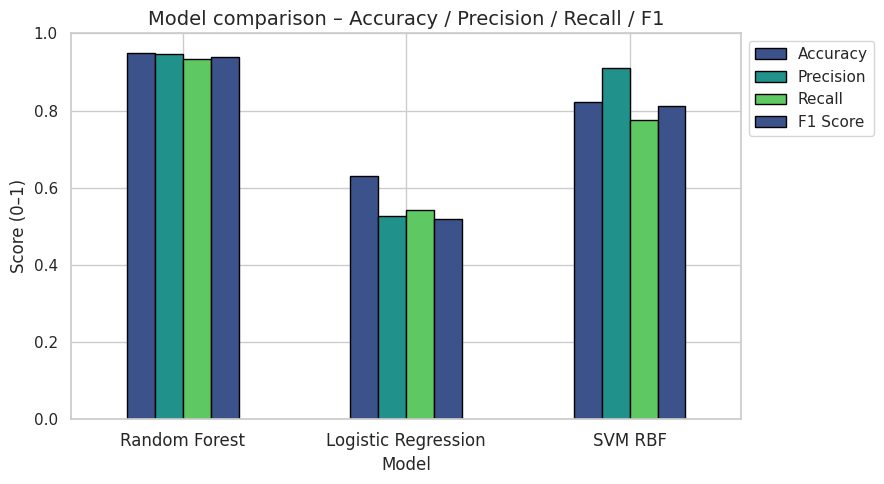

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

score_table = results_df.copy()

sns.set(style="whitegrid")
palette = sns.color_palette("viridis", n_colors=len(score_table))
metrics = ["Accuracy", "Precision", "Recall", "F1 Score"]

# graph
fig1, ax1 = plt.subplots(figsize=(9, 5))
score_table[metrics].plot(kind="bar", ax=ax1, color=palette, edgecolor='black')

ax1.set_title("Model comparison – Accuracy / Precision / Recall / F1", fontsize=14)
ax1.set_ylabel("Score (0–1)", fontsize=12)
ax1.set_ylim(0, 1)
ax1.set_xticklabels(score_table.index, rotation=0, fontsize=12)
ax1.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0), fontsize=11)

plt.tight_layout()
plt.show()

# BOOOOOOM!!!!!! PREDICTION

In [10]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import ipywidgets as widgets
from IPython.display import display

df = pd.read_csv("final_uefa-3.csv", sep=";")
df = df.dropna(subset=["Команда_1", "Команда_2", "Таргет"])

feature_cols = [
    'xG_1', 'xG_2',
    'Удары в створ_1', 'Удары в створ_2',
    'Владение %_1', 'Владение %_2',
    'Угловые_1', 'Угловые_2',
    'Желтые карточки_1', 'Желтые карточки_2',
    'Зрители'
]

target_col = "Таргет"

X = df[feature_cols]
y = df[target_col]

le = LabelEncoder()
df['label'] = le.fit_transform(df["Таргет"])
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = make_pipeline(
    SimpleImputer(strategy='mean'),
    RandomForestClassifier(
        max_depth=None,
        min_samples_split=2,
        n_estimators=200,
        random_state=42
    )
)
model.fit(X_train, y_train)

teams = sorted(set(df["Команда_1"].unique()).union(set(df["Команда_2"].unique())))

team1_dropdown = widgets.Dropdown(options=teams, description='Домашняя:')
team2_dropdown = widgets.Dropdown(options=teams, description='Гостевая:')
output = widgets.Output()

def on_button_clicked(b):
    team1 = team1_dropdown.value
    team2 = team2_dropdown.value

    output.clear_output()

    with output:
        if team1 == team2:
            print("Команды не могут совпадать")
            return

        # Ищем средние значения по домашней и гостевой статистике
        stats1 = df[df["Команда_1"] == team1].mean(numeric_only=True).to_dict()
        stats2 = df[df["Команда_1"] == team2].mean(numeric_only=True).to_dict()

        match_features = {
            'xG_1': stats1.get('xG_1', 0),
            'xG_2': stats2.get('xG_2', 0),
            'Удары в створ_1': stats1.get('Удары в створ_1', 0),
            'Удары в створ_2': stats2.get('Удары в створ_1', 0),
            'Владение %_1': stats1.get('Владение %_1', 50),
            'Владение %_2': stats2.get('Владение %_1', 50),
            'Угловые_1': stats1.get('Угловые_1', 5),
            'Угловые_2': stats2.get('Угловые_1', 5),
            'Желтые карточки_1': stats1.get('Желтые карточки_1', 1),
            'Желтые карточки_2': stats2.get('Желтые карточки_1', 1),
            'Зрители': (stats1.get('Зрители', 30000) + stats2.get('Зрители', 30000)) // 2
        }

        X_new = pd.DataFrame([match_features])
        proba = model.predict_proba(X_new)[0]
        pred_class = le.inverse_transform([np.argmax(proba)])[0]

        print(f"\n Прогноз: {team1} vs {team2}")
        print(f"\n Вероятности:")
        print(f"   Победа {team1}: {proba[1]:.2%}")
        print(f"   Ничья: {proba[0]:.2%}")
        print(f"   Победа {team2}: {proba[2]:.2%}")
        print(f"\nМодель предсказывает: {pred_class}")

button = widgets.Button(description="Прогноз")
button.on_click(on_button_clicked)

display(team1_dropdown, team2_dropdown, button, output)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['xG_1' 'xG_2']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Dropdown(description='Домашняя:', options=('АЕК Афины', 'АЕК Ларнака', 'АЗ Алкмар', 'АИК', 'АПОЭЛ', 'Айнтрахт …

Dropdown(description='Гостевая:', options=('АЕК Афины', 'АЕК Ларнака', 'АЗ Алкмар', 'АИК', 'АПОЭЛ', 'Айнтрахт …

Button(description='Прогноз', style=ButtonStyle())

Output()